# Project Report - TD 4 - Topological Persistence


*by Joseph DE ROFFIGNAC and Ten NGUYEN HANAOKA* 

The purpose of this notebook is to address all the exercises from Lab Session 4 (INF556 – TD4), which focuses on implementing an algorithm to compute persistent homology with coefficients in the field ℤ/2ℤ (also denoted ℤ₂), and on testing it across various filtrations. This Jupyter Notebook basically contains all the answers of the questions, the code and our analysis of the problem.

Additionnally : 
* The folder <i>filtrations</i> contains all the filtrations of the TD in their .txt format
* the file <i>utils.py</i> contains some useful functions
* the folder <i>img</i> contains the diagram of triangulations we designed for some objects of the TD 

---
# Introduction

Let's start with some imports

In [2]:
%pip install tqdm
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import read_filtration, plot_barcodes


We import the <i>read_filtration</i> functions, which allow us to read the text files from the filtrations folder, as well as the <i>plot_barcodes</i> function to display the obtained barcodes.

We decided to replace the Simplex class with a lighter version using dicts. Thus, a simplex is just a dict with items : 
* val (float): the time of appearance in the filtration
* dim (int): the dimension of the simplex
* vert (set[int]): the set of vertex IDs (integers).

In addition, a <i>read_filtration</i> function in utils.py is available, which takes a filename (str) as input and returns a filtration represented as a list of simplices.


An example of how to use <i>read_filtration</i> is given just below (filtration_test is the initial filtration from the TD):

In [4]:
filtration = read_filtration("filtrations/filtration_test.txt")
for simplex in filtration:
    print(simplex)

{'time': 1.0, 'dim': 0, 'vert': {2}}
{'time': 1.0, 'dim': 0, 'vert': {4}}
{'time': 1.0, 'dim': 0, 'vert': {1}}
{'time': 2.0, 'dim': 1, 'vert': {2, 4}}
{'time': 2.0, 'dim': 1, 'vert': {1, 2}}
{'time': 3.0, 'dim': 0, 'vert': {7}}
{'time': 4.0, 'dim': 1, 'vert': {4, 7}}
{'time': 4.0, 'dim': 1, 'vert': {1, 7}}
{'time': 5.0, 'dim': 1, 'vert': {1, 4}}
{'time': 6.0, 'dim': 2, 'vert': {1, 4, 7}}


To simplify our process, we've added a line in <i>read_filtration</i>, that outputs a time sorted filtration.

---
# 1. Boundary matrix

**Question 1** : Compute the boundary matrix B of the filtration from the vector of simplices F. 

We opted for a sparse representation of the boundary matrix: a Python list of sets indexed by the columns of the matrix \(j\). Formally:  

$$
B[j] = \{\, i \in \{0, 1, \dots, m-1\} \;|\; b_{i,j} = 1 \,\}, \quad j \in \{0, 1, \dots, m-1\}
$$

where $(b_{i,j}) \in \mathcal{M}_m(\mathbb{Z}_2)$ is the boundary matrix.  

The advantages are as follows:  

- Memory complexity is linear in the number of 1s in $b$, which in practice is often $O(m)$ or $o(m^2)$.  
- Using Python sets allows efficient computation of symmetric differences between columns during the matrix reduction algorithm (see Q2).


In [5]:
def boundary_matrix(filtration: list[dict]) -> list[set[int]]:
    
    # Dictionnaire : clé = frozenset(vertices), valeur = index dans la filtration
    index_map = {frozenset(s["vert"]): i for i, s in enumerate(filtration)}

    n = len(filtration)
    boundary = [set() for _ in range(n)]

    for j, simplex in enumerate(filtration):
        verts = simplex["vert"]
        dim = simplex["dim"]

        # Génération des faces en retirant un sommet
        if dim > 0:
            for v in verts:
                face = frozenset(verts - {v})
                i = index_map.get(face)
                if i is not None:
                    boundary[j].add(i)

    return boundary

print(boundary_matrix(filtration))

[set(), set(), set(), {0, 1}, {0, 2}, set(), {1, 5}, {2, 5}, {1, 2}, {8, 6, 7}]


To create the boundary matrix, one could iterate over $i$ and $j$ from $1$ to $m$ and test whether $\sigma_i$ is a face of $\sigma_j$, but the complexity would be far too high with this naive algorithm: $\Omega(m^2)$.

However, given a simplex $\sigma_j = [v_0, \dots, v_r]$, there are actually very few simplices $\sigma_i$ that could be a face: they are simply

$$
[v_0, \dots, \hat{v_k}, \dots, v_r], \quad k = 0, \dots, r
$$

Consequently, it suffices to store the simplices and their indices in a dictionary

$$
\text{index\_map} = \{\text{vertices} \mapsto \text{index}\}
$$

(using the immutable type frozenset).  

For each simplex $\sigma_j$, we simply retrieve the indices $i$ of these faces (which are necessarily in the filtration since we are in a simplicial complex).

Regarding complexity:

- Line 4: creation of the index dictionary in $O(m)$  
- Line 9: traversal of the $m$ simplices  
    - For each simplex $\sigma$, the time complexity is $O(\dim(\sigma))$ (Line 15).  
      If the dimension of simplices is bounded (in practice in this assignment we do not exceed dimension 3), each simplex is processed in constant time.  
    - In the case where the dimensions $d$ of simplices can be arbitrarily large, note that a simplex of dimension $d$ has $2^d - 1$ faces. Hence, $d_{\max} = O(\log m)$.

**Conclusion:** The complexity of boundary_matrix is linear in this assignment (and quasi-linear in very few cases, e.g., for balls $\mathbb{B}_d$ and spheres $\mathbb{S}_d$).


---
# 2. Reduction algorithm

**Question 2**  : Implement the reduction algorithm for your representation of the boundary matrix. Evaluate its complexity.

In [6]:
def reduce_boundary_matrix(boundary : list[set[int]]) -> list[set[int]]:
    
    reduced_boundary = boundary.copy()
    m = len(reduced_boundary)

    pivots = {}

    for j in range(m):

        low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        while low_j != -1 and low_j in pivots:

            i = pivots[low_j]

            # Perform column addition (mod 2) : XOR
            reduced_boundary[j] = set(reduced_boundary[j]) ^ set(reduced_boundary[i])
            low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        if low_j != -1:
            pivots[low_j] = j

    return reduced_boundary


**Question 3** Reduce the complexity of the reduction to $O(m^3)$ in the worst case, and to $O(m)$ in cases where the matrix remains sparse throughout, where m is the number of simplices in the filtration. Argue that your code does have the desired worst-case and best-case complexities.

Let $m$ be the number of simplices (columns in the boundary matrix).

The algorithm iterates over each column of the boundary matrix. 
1) For each column, it repeatedly eliminates its pivot by XOR-ing with previously reduced columns until the column's pivot is unique.
2) Each column stores indices of nonzero entries (faces) as a set.

Let's first compute the worse-case complexity.
For each column $j$, let's denote $c_j$ the number of nonzero entries. Computing the pivot and performing a symmetric difference with another column takes each time $\mathcal{O}(c_k+c_i)$ where $c_i$ is the number of nonzero entries in column $i$ that we XOR-ed with.
In the worst-case, each column may be XOR-ed with all previous columns, and hence $\mathcal{O}(m)$ operations per column.
We are repeating this inner loop for all columns, so we get a total complexity of : 
$$\mathcal{O}(m)\cdot\mathcal{O}(m)\cdot\mathcal{O}(m) = \mathcal{O}(m^3)$$


Now if we consider the sparse matrix case : 
If the matrix remains sparse, for each of the $m$ columns, we check its pivot. Finding the pivot (the largest index) is $\mathcal{O}(1)$ since the column is small. 
Each column is XOR-ed with a previously reduced column only if there is a pivot conflict.  
We suppose that in a sparse matrix, the chance of pivot conflict is low, so typically only a constant number of XORs are needed per column. 
Each column costs $\mathcal{O}(1)$  for pivot detection and reduction. With $m$ columns, total operations: $\mathcal{O}(m).$ 

---

**Question 4** Write a function that outputs the barcode from the reduced boundary matrix in a file. The format must be the following one: 1 line per interval, containing 3 numbers: the dimension of the homological feature associated with the interval, the left endpoint of the interval (which is the filtration value associated with the simplex that created the homological feature), the right endpoint (which is the filtration value associated with the simplex that killed the homological feature), separated by white spaces. For instance, interval [b,d) in dimension k is written k b d.

For this part, we've implemented step by step the algorithm given in the end of lecture 4.

In [7]:
def extract_barcodes(reduced_boundary: list[set[int]], filtration: list[dict]) -> list[tuple[int, int, int]]:
    barcodes = []
    paired = set()

    for j, col in enumerate(reduced_boundary):
        if col:
            low_j = max(col)  # sorted list: last element = pivot 
            barcodes.append((filtration[low_j]["dim"], low_j, j))  # (dimension, birth, death)
            paired.add(low_j)
            paired.add(j)

    # Infinite bars: unpaired simplices
    for i, f in enumerate(filtration):
        if i not in paired:
            barcodes.append((f["dim"], i, -1))  # death = ∞

    # Sort by (dimension, birth index, death index)
    barcodes.sort(key=lambda x: (x[0], x[1], x[2] if x[2] != -1 else float('inf')))

    # Convert bars to (dimension, birth time, death time)
    barcodes = [(dim, filtration[birth_idx]["time"], filtration[death_idx]["time"] if death_idx != -1 else float('inf'))
                for dim, birth_idx, death_idx in barcodes]
    return barcodes


Let $m$ be the number of simplices in the filtration.

Each column contains pivot indices. Computing the maximum of a column col takes $O(|\text{col}|)$ time. Summing over all $m$ columns, the total cost is  

   $$
   \sum_{j=0}^{m-1} O(|\text{col}_j|) = O\Big(\sum_{j=0}^{m-1} |\text{col}_j|\Big)
   $$

In a sparse matrix, most columns are small, so $\sum |\text{col}_j| = O(m)$. In the worst case (dense columns), $\sum |\text{col}_j| = O(m^2)$.  

Checking membership in a set takes $O(1)$ on average, and there are $m$ simplices. Hence this step is $O(m)$.

There are at most $m$ barcodes. Sorting by (dimension, birth, death)
costs  

   $$
   O(m \log m)
   $$

Iterating over $m$ barcodes and replacing indices by times costs $O(m)$.

**Worst-case:** $O(m^2 + m \log m) = O(m^2)$ (if columns of the reduced matrix are dense).  
**Best-case (sparse matrix):** $O(m \log m)$ (most columns are small).

Let $k_j$ be the size of column $j$ in the reduced boundary matrix. Then the cost of computing pivots is  
$$
\sum_{j=0}^{m-1} O(k_j)
$$
- In a sparse matrix, $\sum k_j = O(m)$, giving $O(m)$ total.  
- In the worst case, $\sum k_j = O(m^2)$.  

Sorting dominates only in the sparse case, giving $O(m \log m)$.  
Processing unpaired simplices and converting indices to times are $O(m)$.  

Hence, the function scales linearly with $m$ for sparse matrices and quadratically in the worst case.


In [ ]:
def print_barcodes(barcodes: list[tuple[int, int, int]]) -> None:
    for dim, birth, death in barcodes:
        print(f"Dimension: {dim}, Birth: {birth}, Death: {death}")

---
# 3. Experiments

## 3.1. Classical spaces

## Question 5 - Complexity analysis

In [9]:
def process_filtration(filtration: list[dict], name: str) -> float:
    # Returns the time in seconds taken to process the filtration
    start_time = time.time()
    B = boundary_matrix(filtration)
    print("Boundary matrix computed.")
    barcodes = extract_barcodes(reduce_boundary_matrix(B), filtration)
    print("Barcodes extracted.")
    end_time = time.time()
    plot_barcodes(barcodes, name=name)
    return end_time - start_time

**Question 5/6** : Compute triangulations and barcodes for some classical topological spaces

Dans toutes les filtrations que nous proposons, le filtration value de chaque simplexe sera égale à sa dimension. Il est clair que cela définit bien un ordre topologique sur la filtration. Par exemple les sommets seront insérés au temps 0.0, les arêtes au temps 1.0, etc. 

Cela améliora la lecture des barcodes puisqu'il y aura en pratique très peu de timestamp et donc de bar distinctes.

Par conséquent, on se contente seulement de définir la triangulation des objets étudiés.

### $\mathbb{B}_d$ and $\mathbb{S}_d$

Pour les boules et les sphères en dimension $d$, la filtration est plutôt directe : 
- Pour une boule en dimension d, on considère des sommets $0,...,d$, puis on pose $K := \mathcal{P}([\![0,d]\!]) \\ \{\emptyset\}$, l'ensemble des parties non-vides de $[\![0,d]\!]$
- Pour une sphère en dimension $d$, on prend la filtration de $\mathbb{B}_{d+1}$ où l'on enlève le simplexe de dimension $d+1$.

Boundary matrix computed.
Barcodes extracted.


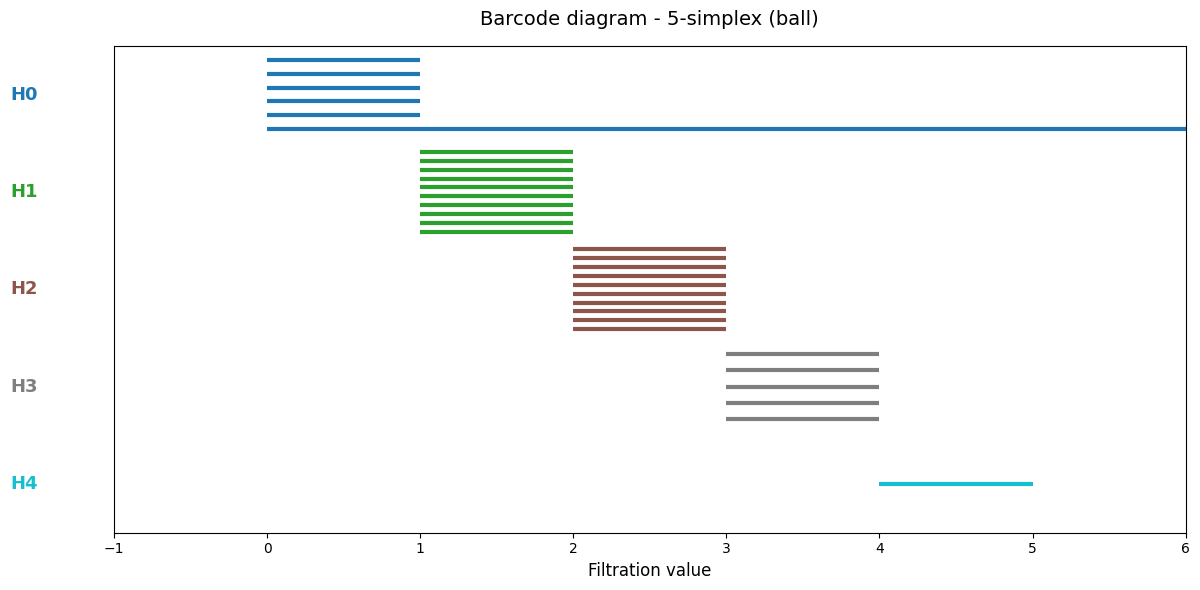

Boundary matrix computed.
Barcodes extracted.


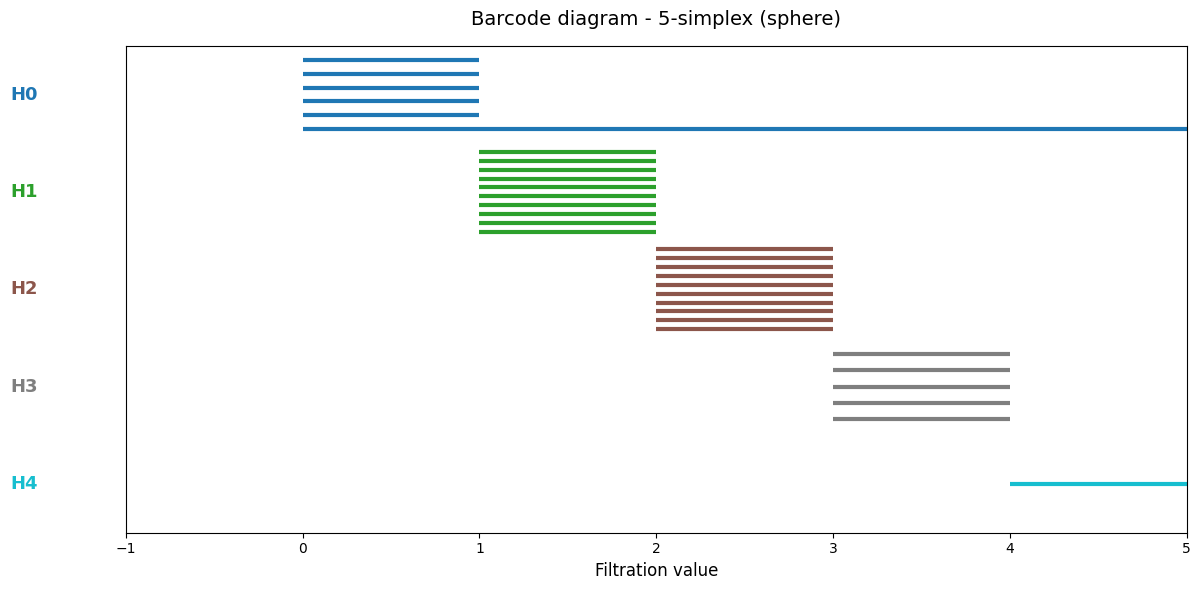

0.0001971721649169922

In [11]:
from itertools import combinations

def create_filtration(shape = "ball", dim = 10):
    # énumérer les parties d'une liste de points
    if shape == "ball":
        points = list(range(dim + 1))
    elif shape == "sphere":
        points = list(range(dim + 2))
    else:
        raise Exception("Shape should be \"ball\" or \"sphere\"")

    filtration = []
    for r in range(dim+1):
        for comb in combinations(points, r+1):
            filtration.append({"vert": set(comb), "dim": r, "time": r})

    return filtration

process_filtration(create_filtration("ball", 5), name="5-simplex (ball)")
process_filtration(create_filtration("sphere", 4), name="5-simplex (sphere)")

On retrouve le résultat du cours et des exercices : 
Pour la boule $B_d$, on a \beta_0 = 1 et \beta_r = 0 pour r \geqslant 1.
Pour la sphère $S_d$, on a \beta_0 = \beta_d = 1 et \beta_r = 0 sinon.

Notons que les barres du code barre s'organisent en blocs de barres $[d, d+1)$, auquel on ajoute les barres infinies $[d, +\infty)$. Cela est dû qu fait que les seuls simplexes pouvant créer ou tuer une barre en dimension d sont au temps d+1.

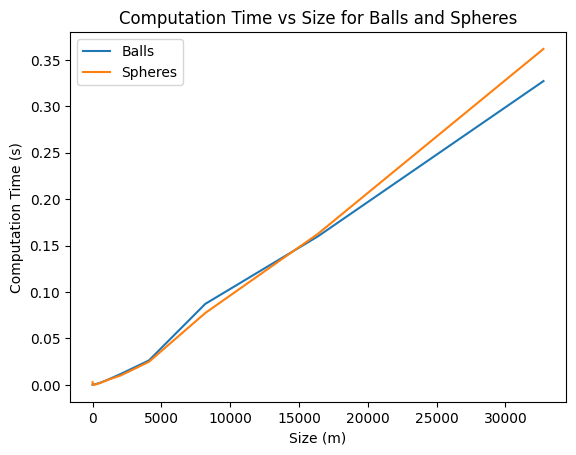

In [12]:
# Tracé le temps de calcul en fonction de la dimension pour les deux types de filtrations
max_dim = 15

ball_sizes = [2**(d+1) - 1 for d in range(0, max_dim)]
sphere_sizes = [2**(d+2) - 2 for d in range(0, max_dim-1)]
ball_times = []
sphere_times = []
for dim in range(0, max_dim):
    start_time = time.time()
    _ = reduce_boundary_matrix(boundary_matrix(create_filtration("ball", dim)))
    ball_time = time.time() - start_time
    ball_times.append(ball_time)
for dim in range(0, max_dim-1):
    start_time = time.time()
    _ = reduce_boundary_matrix(boundary_matrix(create_filtration("sphere", dim)))
    sphere_time = time.time() - start_time
    sphere_times.append(sphere_time)

plt.plot(ball_sizes, ball_times, label="Balls")
plt.plot(sphere_sizes, sphere_times, label="Spheres")
plt.xlabel("Size (m)")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Size for Balls and Spheres")
plt.legend()
plt.show()

On remarque que le temps de calcul pour les sphères et les boules est pratiquement linéaire en fonction de la taille de la filtration.
Cela corrobore le résultat de la question 3. Notons que la matrice contient O(m) éléments non nuls dans le cas des boules (et aussi des sphères).

En effet, pour une boule de dimension d et pour k \in [\![1, d]\!], la filtration contient \binom{d+1}{k+1} simplices de dimension k, et chaque simplex de dimension k a k+1 faces de dimension k-1. Ainsi, le nombre total d'éléments non nuls dans la matrice des frontières est :
$\sum_{k=1}^{d} (k+1) \binom{d+1}{k+1} = (d+2) 2^{d} - (d+1) = O(m)$.

---
### Moebius band

<p align="center">
    <img src="img/triangulation_moebius_band.png" alt="Moebius band triangulation" width="300", center />
</p>

On peut utiliser une triangulation similaire à celle du cylindre en utilisant 6 sommets, 12 arêtes, 6 triangles, comme représentée ci-dessus.

Boundary matrix computed.
Barcodes extracted.


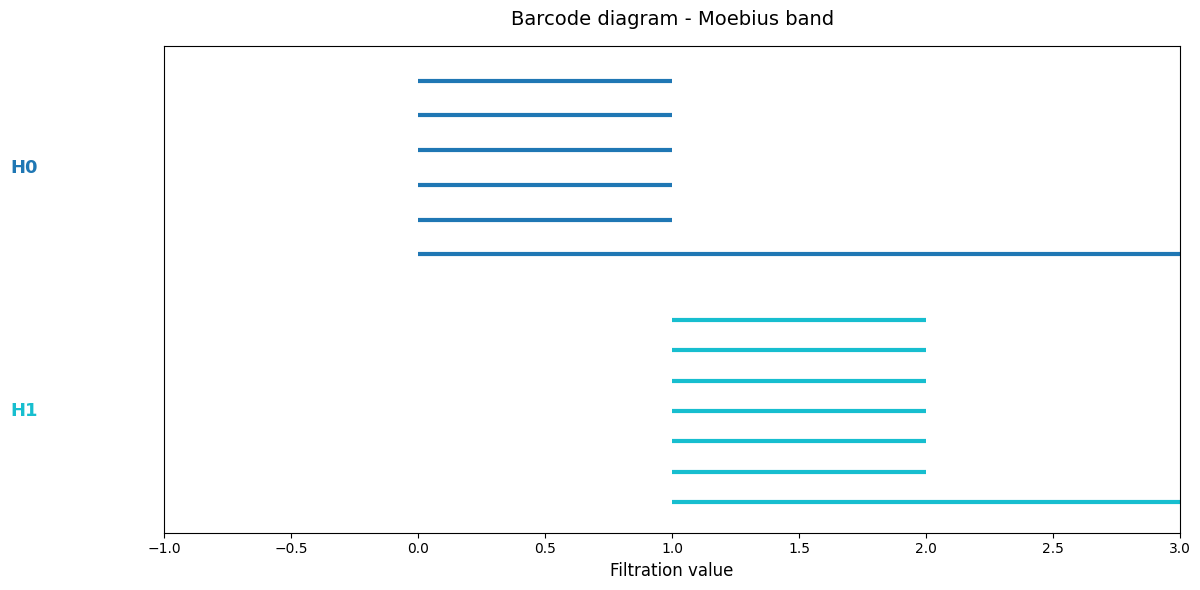

0.00026106834411621094

In [16]:
filtration = read_filtration("filtrations/filtration_moebius.txt")
process_filtration(filtration, name="Moebius band")

---
### Torus

<p align="center">
    <img src="img/triangulation_torus.png" alt="Torus triangulation" width="300", center />
</p>

La triangulation utilisée est similaire à celle vue lors des exercices. À cause du recollement des bords haut et bas, on est forcé d'ajouter 3 nouveaux sommets. On a maintenant 9 sommets, 27 arêtes et 18 triangles.

Boundary matrix computed.
Barcodes extracted.


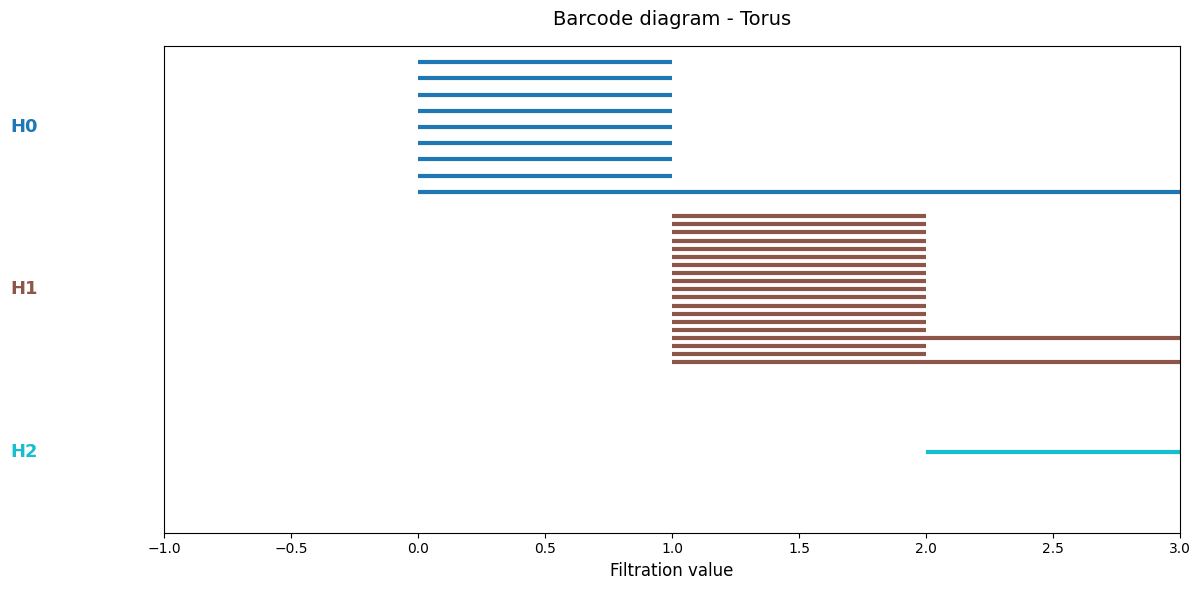

0.0002589225769042969

In [13]:
filtration = read_filtration("filtrations/filtration_torus.txt")
process_filtration(filtration, name="Torus")

---
### Klein bottle

<p align="center">
    <img src="img/triangulation_klein_bottle.png" alt="Klein bottle triangulation" width="300", center />
</p>

On reprend la même triangulation que pour le torus, mais on inverse la représentation des sommets 3 et 4 sur le bord droit.


---

### Projective plane $\mathbb{RP}^2$

<p align="center">
    <img src="img/triangulation_projective_plane.png" alt="Projective plane triangulation" width="300", center />
</p>

Boundary matrix computed.
Barcodes extracted.


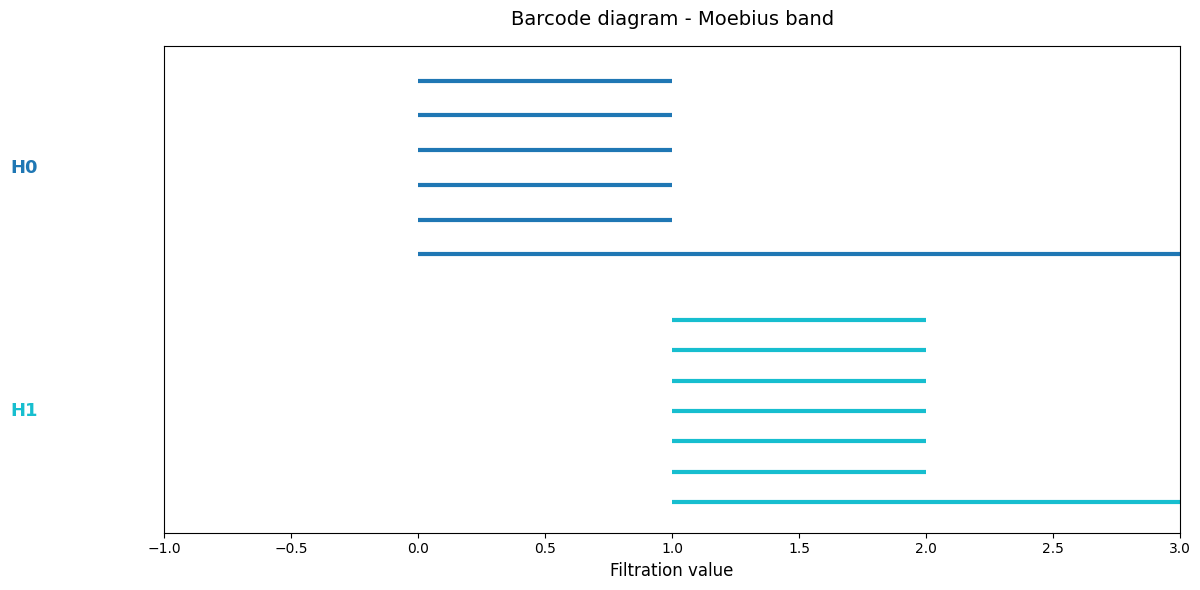

In [14]:
filtration = read_filtration("filtrations/filtration_moebius.txt")
_ = process_filtration(filtration, name="Moebius band")

## 3.2. Simulated data

### Filtration A

In [15]:
filtration_a = read_filtration("filtrations/filtration_A.txt")
duration = process_filtration(filtration_a, name="Filtration A")
print("Size of filtration A:", len(filtration_a))
print("Time to process filtration A:", duration, "seconds")

Boundary matrix computed.


KeyboardInterrupt: 

Size of filtration A : 428643
Time to process filtration A: 108.70776009559631 seconds

Analyse de l'objet topologique sous-jacent :

- D'après le diagramme du barcode, on mesure \beta_0 = 1, \beta_1 = 0, \beta_2 = 0, etc.... Ainsi, l'objet topologique correspondant est connexe, sans trous, ni cavité, .... Toutes les variétés connexes parties de cet objet sont homotopes à un point.
- On peut également étudier la construction dynamique de la filtration. Au début, tous les sommets sont générés de manière individuelle (c'est là que naissent la plupart des barres de H_0). Ensuite les arêtes sont progressivement rajoutées, ce qui supprime de nombreuses composantes connexes (les points se rejoignent, les barres de H_0 meurent). Enfin, quelques triangles (simplexes 2D) viennent éliminer tous les nombreux 1-cycles créés, sans créer de cavité.
Conclusion : Globalement, les simplexes sont rajoutés dans l'ordre de leur dimension.

### Filtration B

Boundary matrix computed.
Barcodes extracted.


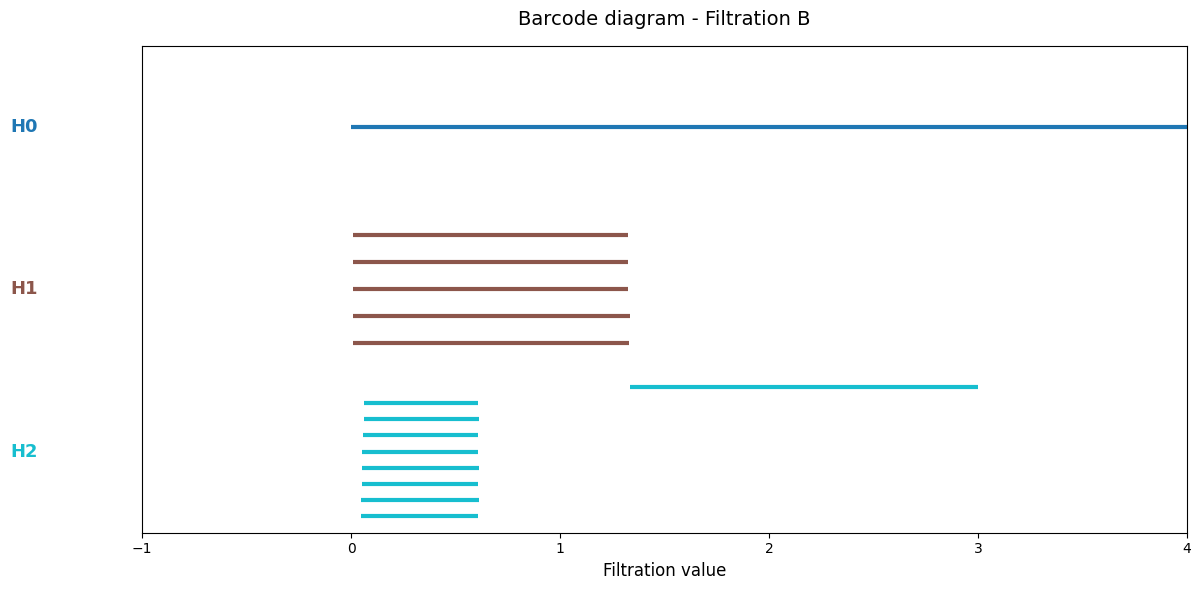

Size of filtration B: 108161
Time to process filtration B: 5.467949151992798 seconds


In [ ]:
filtration_b = read_filtration("filtrations/filtration_B.txt")
duration = process_filtration(filtration_b, name="Filtration B")
print("Size of filtration B:", len(filtration_b))
print("Time to process filtration B:", duration, "seconds")

Size of filtration B: 108161
Time to process filtration B: 5.4838478565216064 seconds

Analyse de l'objet topologique sous-jacent :
- Les nombres de Betti sont les mêmes que pour la filtration A. On a donc la même analyse que pour l'objet A.
- Dans la filtration B, les sommets sont rajoutés puis les arêtes très rapidement après pour les relier (puisque toutes les barres H_0 étaient très courtes sauf la seule infinie). Ensuite quelques cavités et 1-cycles se forment par l'ajout de triangles et d'arêtes. Les cavités sont détruites par l'ajout de simplexes 3D , puis les cycles par l'ajout de triangles vers t = 1.3 en échelle log. Apparemment, ces derniers triangles placés créent une cavité centrale (grosse barre de H_2)


### Filtration C

Boundary matrix computed.
Barcodes extracted.


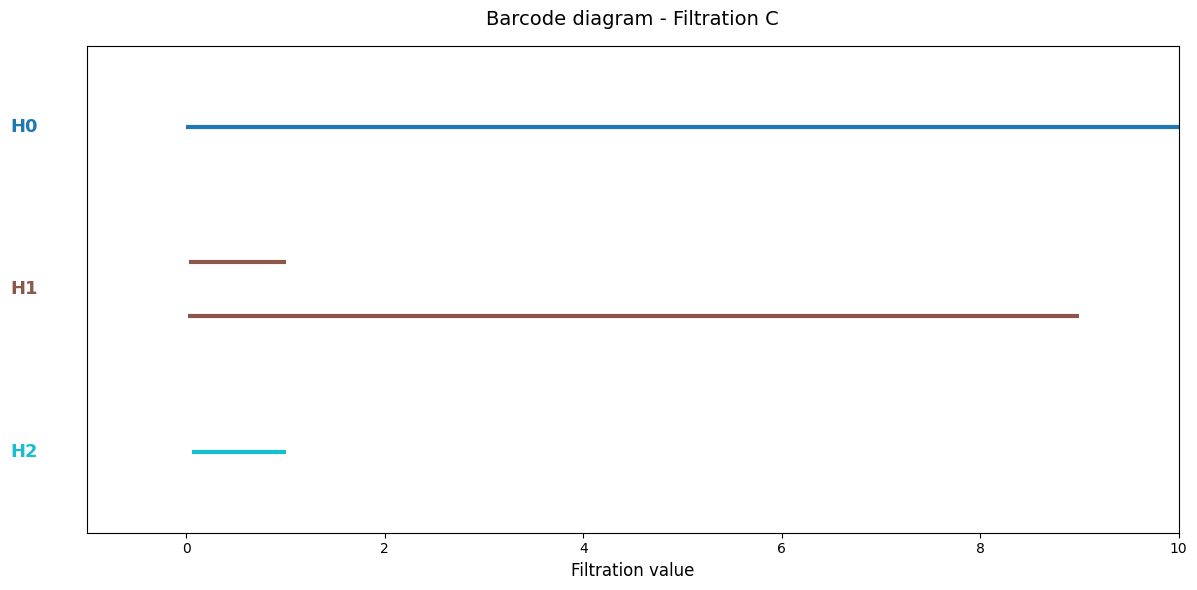

Size of filtration C: 180347
Time to process filtration C: 14.59340786933899 seconds


In [ ]:
filtration_c = read_filtration("filtrations/filtration_C.txt")
duration = process_filtration(filtration_c, name="Filtration C")
print("Size of filtration C:", len(filtration_c))
print("Time to process filtration C:", duration, "seconds")

Size of filtration C: 180347
Time to process filtration C: 14.717528820037842 seconds

Analyse de l'objet topologique sous-jacent :
- Là encore, les nombres de Betti sont les mêmes que pour la filtration A et B. On a donc la même analyse que pour ces objets.
- Dans la filtration C, on rajoute les sommets pratiquement en même temps que de nombreux arêtes et triangles, à tel point que le complexe devient connexe très rapidement (ajout d'arête pour chaque nouveau sommet) et avec peu de 1-cycles (ajout de triangles pour boucher les 1-cycles). Un cycle très large subsiste pour une longue durée. A partir de t=1, la phase de remplissage commence : la cavité est découpée en de nombreuses cavités, qui sont rapidement bouchées par des simplexes 3D.


### Filtration D

Boundary matrix computed.
Barcodes extracted.


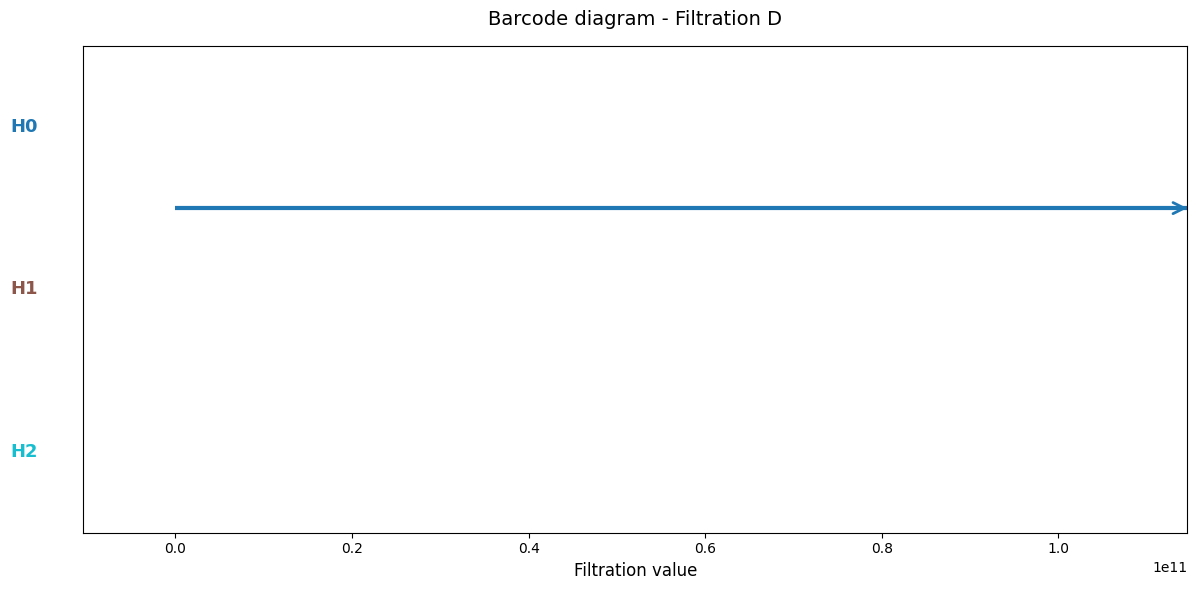

Size of filtration D: 2716431
Time to process filtration D: 586.8552062511444 seconds


In [ ]:
filtration_d = read_filtration("filtrations/filtration_D.txt")
duration = process_filtration(filtration_d, name="Filtration D")
print("Size of filtration D:", len(filtration_d))
print("Time to process filtration D:", duration, "seconds")

Size of filtration D: 2716431 \
Time to process filtration D: 586.8552062511444 seconds

Analyse de l'objet topologique sous-jacent :
- Là encore, les nombres de Betti sont les mêmes que pour les filtrations précédentes. On a donc la même analyse que pour ces objets.
- Dans la filtration D, l'ordre de la construction se fait par petits clusters / boules. Celles-ci sont construites de manière assez indépendantes puis sont fusionnées ensuite (comme dans la filtration A)
C'est à ce moment là que les barres de H_0 disparaissent.
Vers t \in [-7,-5] en échelle log, le 1-cycle initial est découpé en de nombreux 1-cycles par le rajout d'arêtes, et sont régulièrement supprimés par l'ajout de triangles pour boucher ces surfaces. 
À t=0, le même phénomène se produit une dimension plus haute, et de manière plus instantané. La grande cavité est découpée par l'ajout de triangles, qui sont bouchés très efficacement par l'ajout de derniers simplexes 3D.

Conclusion sur les 4 filtrations

Finalement, l'obtention des barcode permet de mieux comprendre la topologie des complexes simpliciels partiels au cours du temps et à la fin du processus. Ils permettent également de comprendre l'ordre dans lequel les simplexes sont ajoutés :
- Dans l'ordre de leur dimension (filtration A)
- Dans l'ordre des sommets : on rajoute, un sommet puis on le connecte en rajoutant tous les simplexes qui le contiennent (filtration B,C)
- Construction par boules/clusters : certains clusters sont complétés et reliés entre eux dans un second temps (filtration D)

Néanmoins, l'algorithme ne permet pas d'extraire d'information plus géométrique sur la structure des données, car les nombres de betti (même à tout instant ne caractérise pas un objet géométrique/topologique).

<table>
  <thead>
    <tr>
      <th style="text-align:left;">Filtration</th>
      <th style="text-align:right;">Size</th>
      <th style="text-align:right;">Time (s)</th>
      <th style="text-align:right;">Time / Size (s / élément)</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>A</td><td style="text-align:right;">428 643</td><td style="text-align:right;">108.7078</td><td style="text-align:right;">0.0002536</td></tr>
    <tr><td>B</td><td style="text-align:right;">108 161</td><td style="text-align:right;">5.4838</td><td style="text-align:right;">0.0000507</td></tr>
    <tr><td>C</td><td style="text-align:right;">180 347</td><td style="text-align:right;">14.7175</td><td style="text-align:right;">0.0000816</td></tr>
    <tr><td>D</td><td style="text-align:right;">2 716 431</td><td style="text-align:right;">444.8562</td><td style="text-align:right;">0.0001638</td></tr>
  </tbody>
</table>

In [ ]:
# TODO : report, answer questions, complexity analysis, plots, analysis of graphs.
# >>> jupyter notebook
# + représentation graphique + tableau des temps